In [ ]:
import sys
sys.path.append("..")

from models.base_model import PatchTrADencoder
import yaml 
from types import SimpleNamespace
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from data_utils import get_artificial_data, get_visu_artificial_signals, SyntheticDataset, get_ecg_signals

PROJECTION="T-SNE"

In [ ]:
# Script to visualize the embeddings of a pre-trained encoder using PCA or t-SNE.

def get_manifolds_embeddings(encoder, data, projection=PROJECTION):
    with torch.no_grad():
        _, encoding = encoder(data)
    encoding = encoding.squeeze(1).sum(dim=1).cpu().numpy()
    if projection == "PCA":
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(encoding)
    elif projection == "T-SNE":
        tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
        reduced_data = tsne.fit_transform(encoding)
    else:
        raise ValueError("Projection method not supported")
    return reduced_data

In [3]:
config_pre = yaml.load(open("../conf/encoder/config_encoder_base.yaml"), Loader=yaml.FullLoader)
config = SimpleNamespace(**config_pre)

encoder = PatchTrADencoder(config)

checkpoint_path = "../checkpoints/ts_jepa_vicreg_base" + "_" + "1" + ".ckpt"
checkpoint = torch.load(checkpoint_path, weights_only=True)
encoder.load_state_dict(checkpoint)

<All keys matched successfully>

# Encoding of different signals:

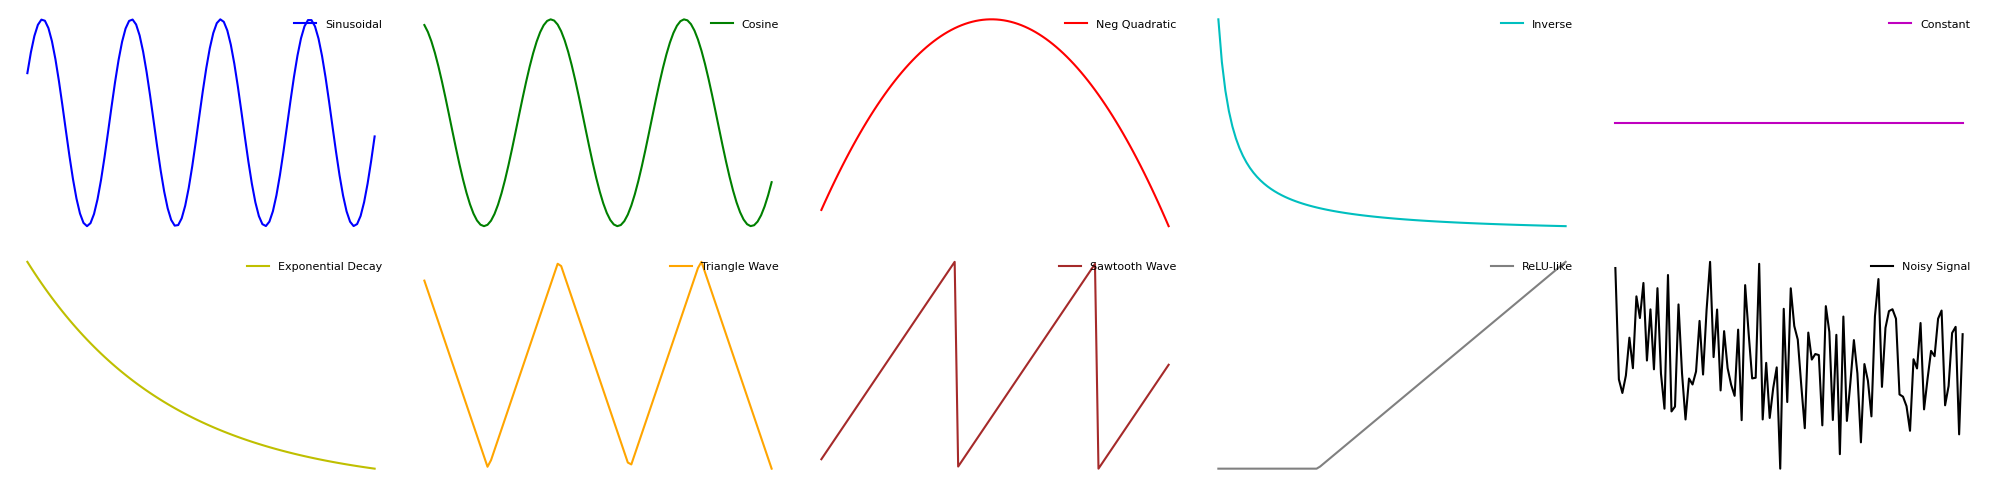

In [4]:
fig = get_visu_artificial_signals()

/home/svilhes/anaconda3/envs/anots/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


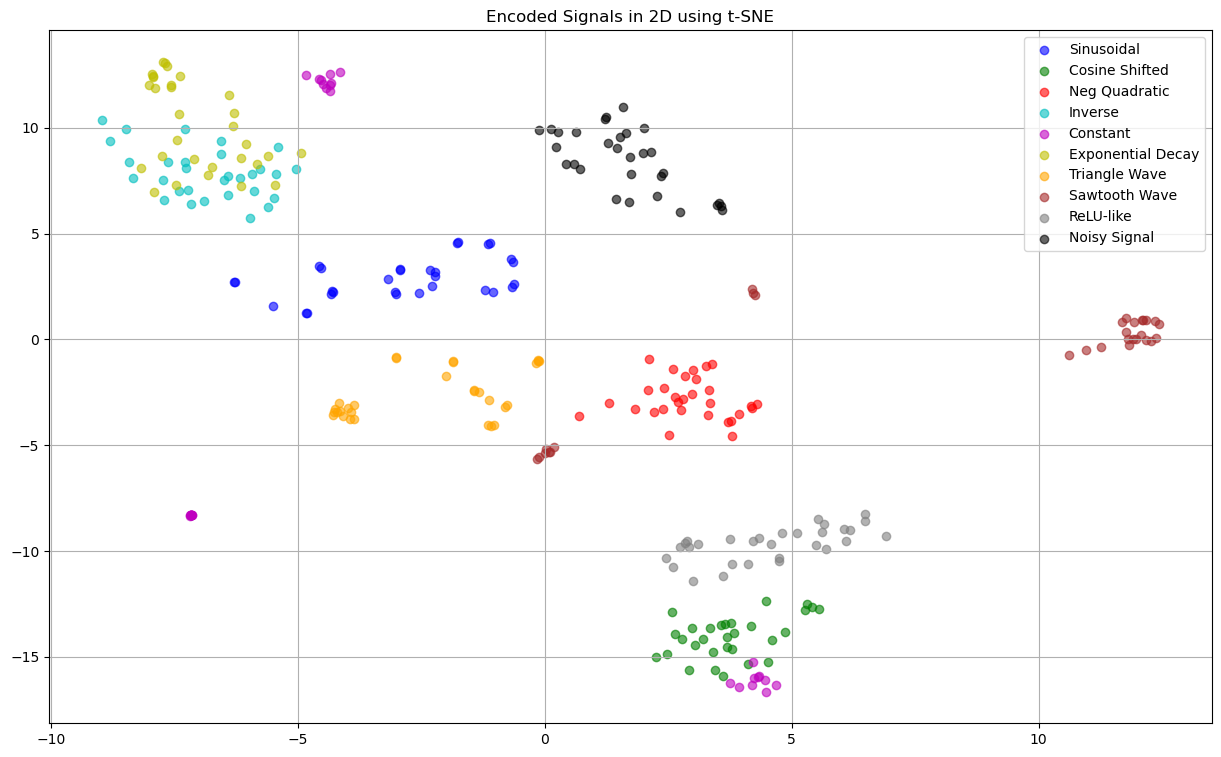

In [ ]:
all_signals, n_start_points = get_artificial_data()

embeddings_2d = get_manifolds_embeddings(encoder, all_signals, projection=PROJECTION)

plt.figure(figsize=(15, 9))
labels = [
    "Sinusoidal",
    "Cosine Shifted",
    "Neg Quadratic",
    "Inverse",
    "Constant",
    "Exponential Decay",
    "Triangle Wave",
    "Sawtooth Wave",
    "ReLU-like",
    "Noisy Signal"
]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'brown', 'gray', 'black']

for i, label in enumerate(labels):
    plt.scatter(
        embeddings_2d[i*n_start_points*3:(i+1)*n_start_points*3, 0],
        embeddings_2d[i*n_start_points*3:(i+1)*n_start_points*3, 1],
        alpha=0.6, label=label, color=colors[i % len(colors)]
    )

plt.legend()
plt.title(f"Encoded Signals in 2D using {PROJECTION}")
plt.grid(True)
plt.show()

### From this part, the implementation is inspired by the paper "MOMENT: A Family of Open Time-series Foundation Models"

# Encoding of sinusoidal waves of different frequencies:

In [ ]:
synthetic_dataset = SyntheticDataset(n_samples=1024, freq=1, freq_range=(1, 32), 
                                     noise_mean=0., noise_std=0.1, random_seed=13)

y, c = synthetic_dataset.gen_sinusoids_with_varying_freq()
y = y.permute(0, 2, 1)

n_samples = synthetic_dataset.n_samples
seq_len = synthetic_dataset.seq_len

embeddings_2d = get_manifolds_embeddings(encoder, y, projection=PROJECTION)

/home/svilhes/anaconda3/envs/anots/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


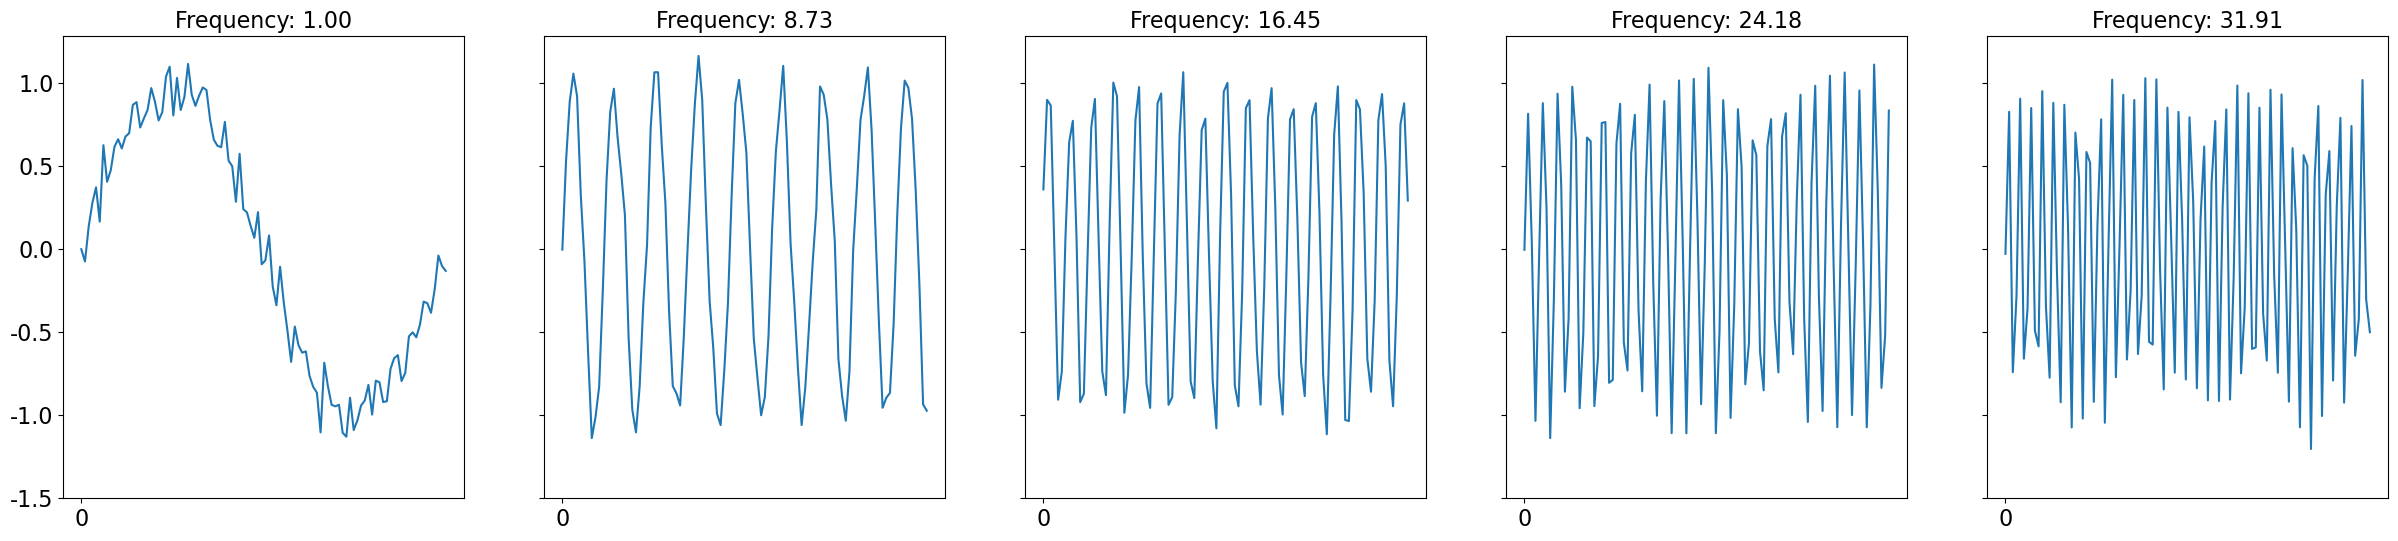

In [7]:
# Visualize the data
fig, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
axs.flatten()
for i, idx in enumerate(np.arange(0, n_samples+1, n_samples//4-1)):
    axs[i].plot(y[idx].squeeze().numpy())
    axs[i].set_xticks(
        ticks=np.arange(0, seq_len+1, 128), 
        labels=np.arange(0, seq_len+1, 128), 
        fontdict={"fontsize" : 16})
    axs[i].set_title("Frequency: {:.2f}".format(c[:, 0][idx].squeeze().numpy(), ), fontsize=16)
axs[0].set_yticks(
        ticks=np.arange(-1.5, 1.5, 0.5), 
        labels=np.arange(-1.5, 1.5, 0.5),
        fontdict={"fontsize" : 16})

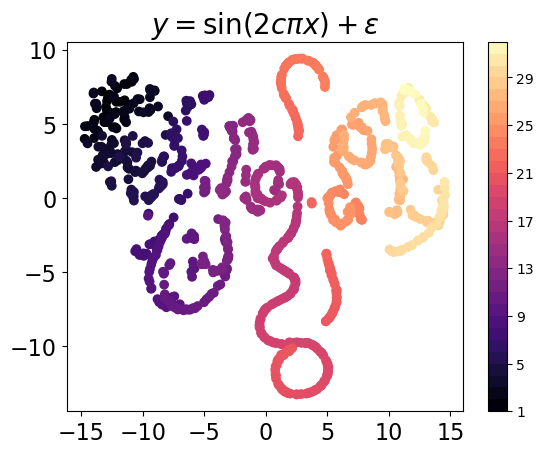

In [8]:
plt.title(f"$y = \sin(2c \pi x) + \epsilon$", fontsize=20)
plt.scatter(embeddings_2d[:, 0], 
            embeddings_2d[:, 1], c=c[:, 0].squeeze().numpy(), cmap='magma')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(boundaries=np.arange(
    synthetic_dataset.freq_range[0], synthetic_dataset.freq_range[1]+1, 1))

# Encoding of sinusoidal waves of different amplitudes:

In [ ]:
synthetic_dataset = SyntheticDataset(
    n_samples=2048, seq_len=100, freq=16, amplitude_range=(1/4, 4), 
    noise_mean=0., noise_std=0.1, random_seed=13)

y, c = synthetic_dataset.gen_sinusoids_with_varying_amplitude()
y = y.permute(0, 2, 1)
n_samples = synthetic_dataset.n_samples
seq_len = synthetic_dataset.seq_len

embeddings_2d = get_manifolds_embeddings(encoder, y, projection=PROJECTION)

/home/svilhes/anaconda3/envs/anots/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


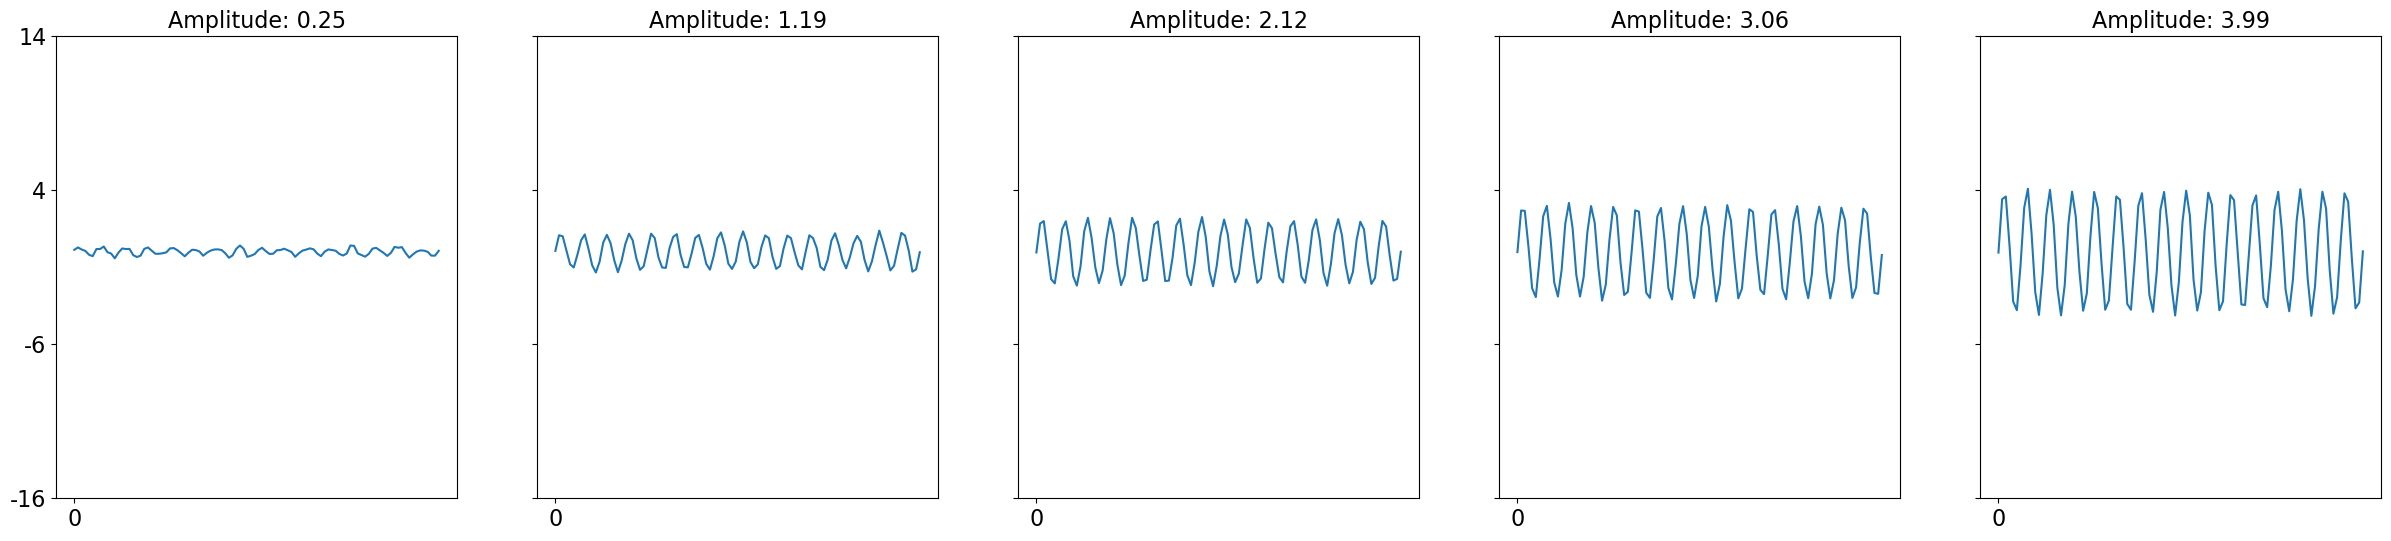

In [10]:
# Visualize the data
fig, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
axs.flatten()
for i, idx in enumerate(np.arange(0, n_samples+1, n_samples//4-1)):
    axs[i].plot(y[idx].squeeze().numpy())
    axs[i].set_xticks(
        ticks=np.arange(0, seq_len+1, 128), 
        labels=np.arange(0, seq_len+1, 128), 
        fontdict={"fontsize" : 16})
    axs[i].set_title("Amplitude: {:.2f}".format(c[:, 0][idx].squeeze().numpy(), ), fontsize=16)
axs[0].set_yticks(
        ticks=np.arange(-16, 16, 10), 
        labels=np.arange(-16, 16, 10),
        fontdict={"fontsize" : 16})

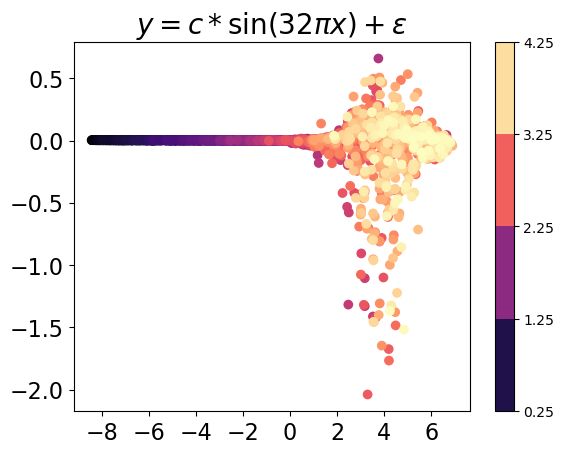

In [11]:
plt.title(f"$y = c*\sin(32\pi x) + \epsilon$", fontsize=20)
plt.scatter(embeddings_2d[:, 0], 
            embeddings_2d[:, 1], c=c[:, 0].squeeze().numpy(), cmap='magma')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(boundaries=np.arange(synthetic_dataset.amplitude_range[0], synthetic_dataset.amplitude_range[1]+1, 1))

# Encoding of sinusoidal waves of different trends:

In [ ]:
synthetic_dataset = SyntheticDataset(n_samples=2048, freq=16, trend_range=(1/8, 8), 
                                     noise_mean=0., noise_std=0.1, random_seed=13)

y, c = synthetic_dataset.gen_sinusoids_with_varying_trend()
y = y.permute(0, 2, 1)
_, t = synthetic_dataset._generate_x()
trend = t**c
n_samples = synthetic_dataset.n_samples
seq_len = synthetic_dataset.seq_len

embeddings_2d = get_manifolds_embeddings(encoder, y, projection=PROJECTION)

/home/svilhes/anaconda3/envs/anots/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


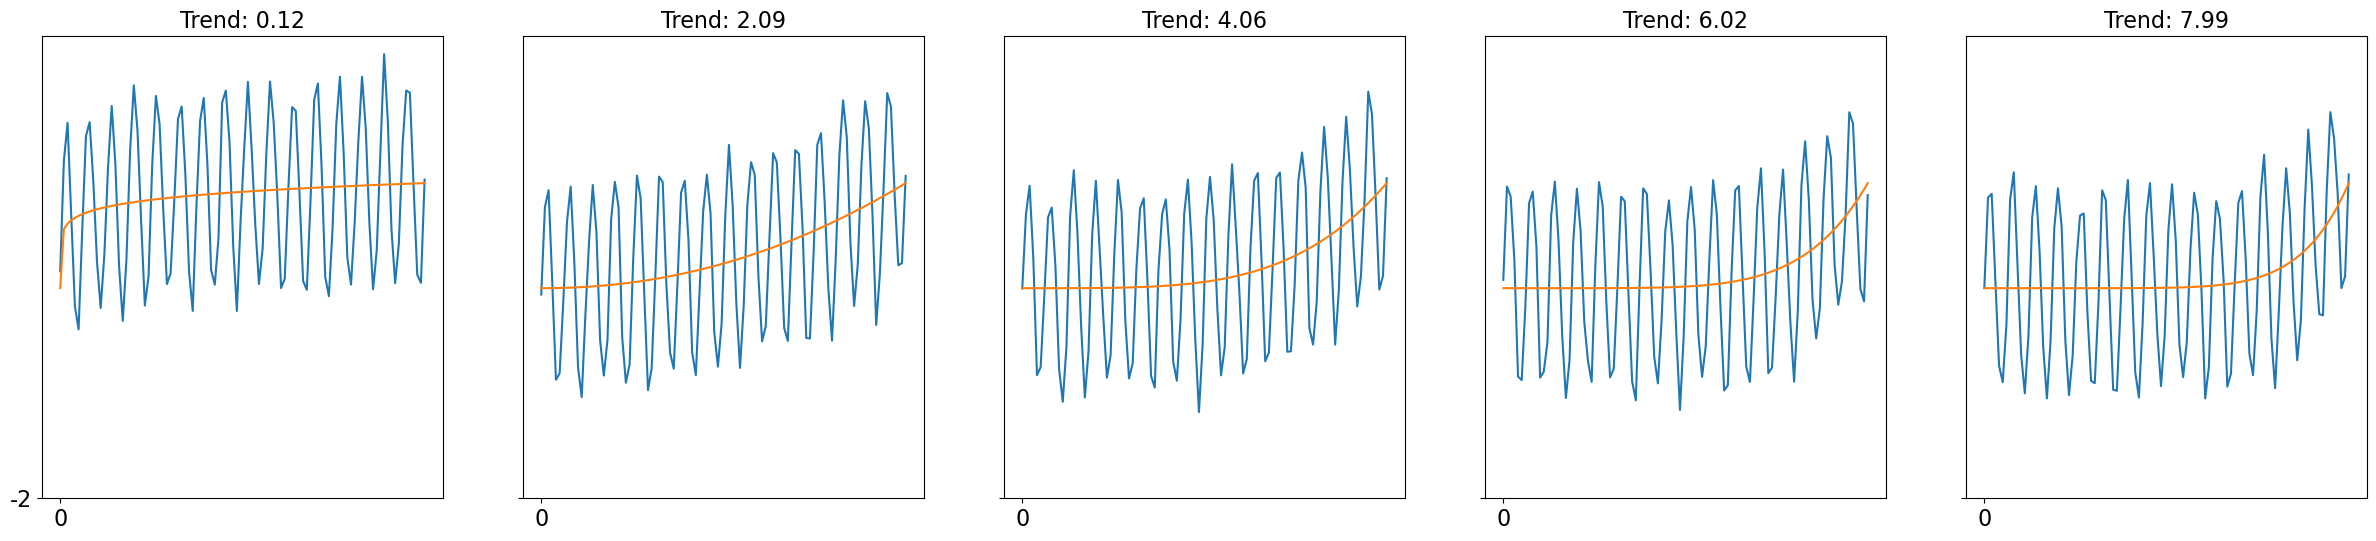

In [13]:
# Visualize the data
fig, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
axs.flatten()
for i, idx in enumerate(np.arange(0, n_samples+1, n_samples//4-1)):
    axs[i].plot(y[idx].squeeze().numpy())
    axs[i].plot(trend[idx].squeeze().numpy())
    axs[i].set_xticks(
        ticks=np.arange(0, seq_len+1, 128), 
        labels=np.arange(0, seq_len+1, 128), 
        fontdict={"fontsize" : 16})
    axs[i].set_title("Trend: {:.2f}".format(c[:, 0][idx].squeeze().numpy(), ), fontsize=16)
axs[0].set_yticks(
        ticks=np.arange(-2, 2, 10), 
        labels=np.arange(-2, 2, 10),
        fontdict={"fontsize" : 16})

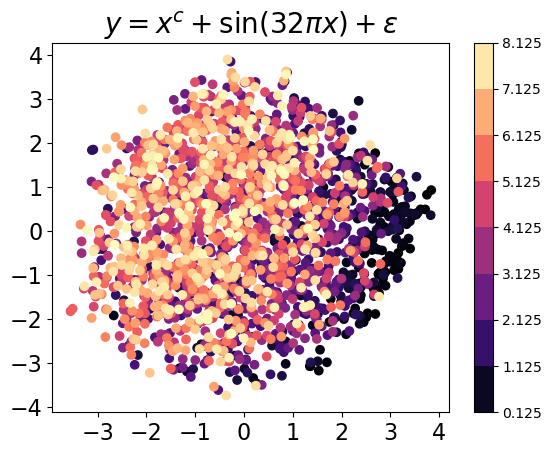

In [14]:
plt.title(f"$y = x^c + \sin(32\pi x) + \epsilon$", fontsize=20)
plt.scatter(embeddings_2d[:, 0], 
            embeddings_2d[:, 1], c=c[:, 0].squeeze().numpy(), cmap='magma')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(boundaries=np.arange(synthetic_dataset.trend_range[0], synthetic_dataset.trend_range[1]+1, 1))

# Encoding of sinusoidal waves of baselines shift:

In [ ]:
synthetic_dataset = SyntheticDataset(n_samples=2048, freq=16, baseline_range=(-2, 2), 
                                     noise_mean=0., noise_std=0.1, random_seed=13)

y, c = synthetic_dataset.gen_sinusoids_with_varying_baseline()
y = y.permute(0, 2, 1)
n_samples = synthetic_dataset.n_samples
seq_len = synthetic_dataset.seq_len

embeddings_2d = get_manifolds_embeddings(encoder, y, projection=PROJECTION)

/home/svilhes/anaconda3/envs/anots/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


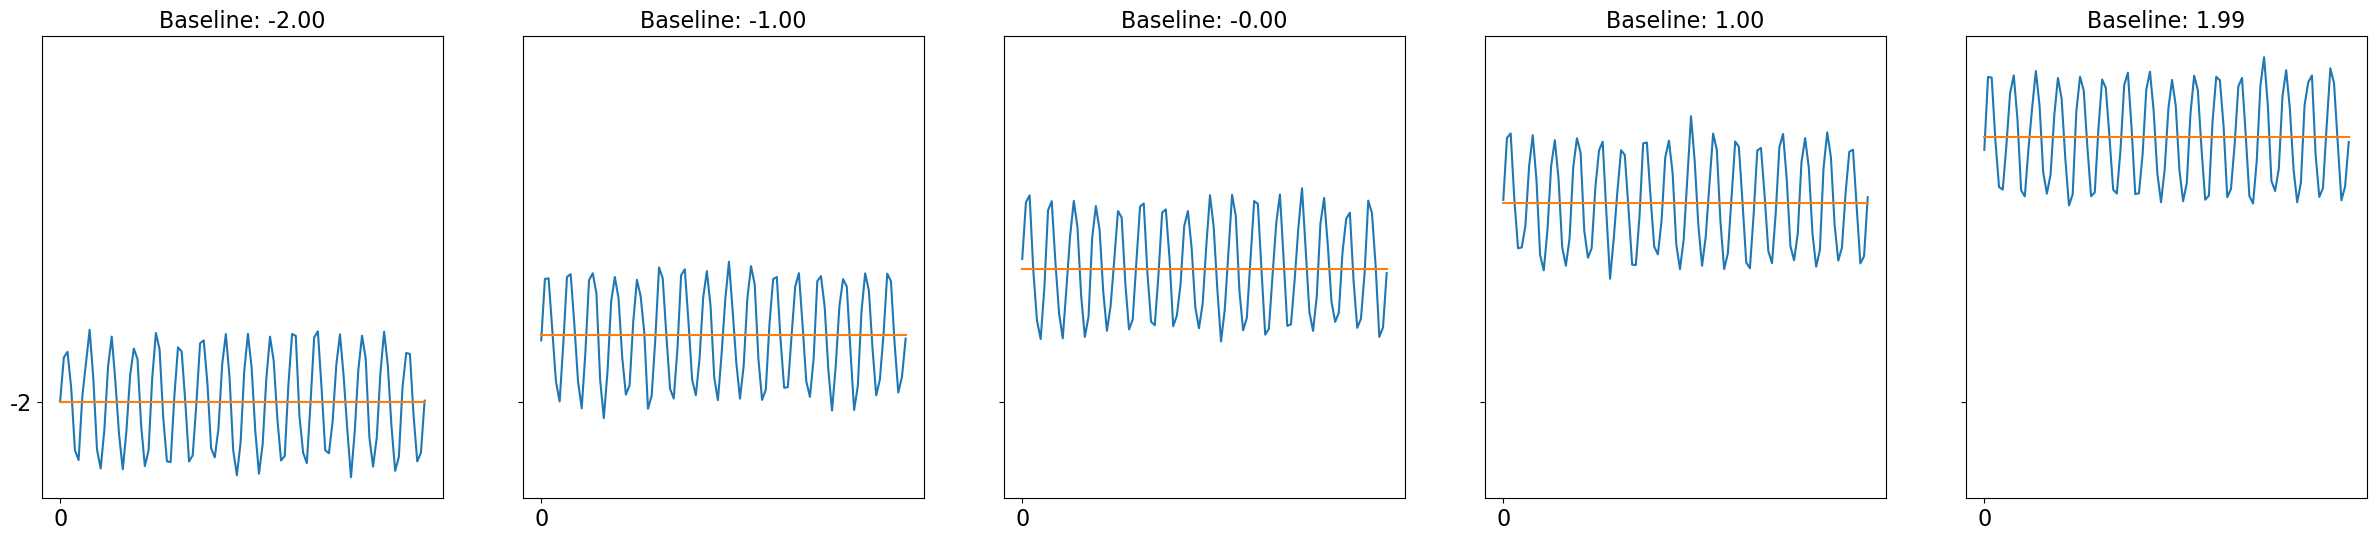

In [16]:
# Visualize the data
fig, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
axs.flatten()
for i, idx in enumerate(np.arange(0, n_samples+1, n_samples//4-1)):
    axs[i].plot(y[idx].squeeze().numpy())
    axs[i].plot(c[idx].squeeze().numpy())
    axs[i].set_xticks(
        ticks=np.arange(0, seq_len+1, 128), 
        labels=np.arange(0, seq_len+1, 128), 
        fontdict={"fontsize" : 16})
    axs[i].set_title("Baseline: {:.2f}".format(c[:, 0][idx].squeeze().numpy(), ), fontsize=16)
axs[0].set_yticks(
        ticks=np.arange(-2, 2, 10), 
        labels=np.arange(-2, 2, 10),
        fontdict={"fontsize" : 16})

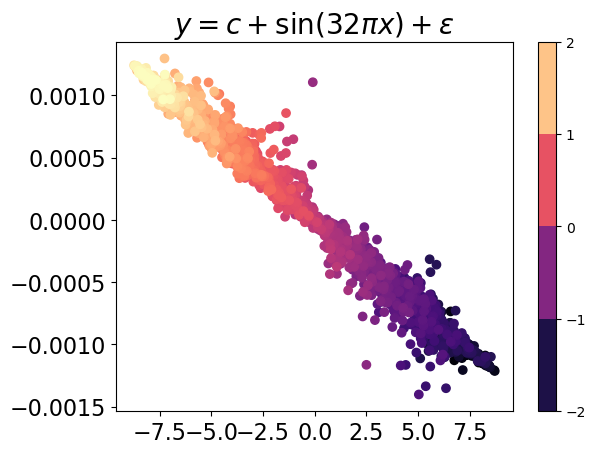

In [17]:
plt.title(f"$y = c + \sin(32\pi x) + \epsilon$", fontsize=20)
plt.scatter(embeddings_2d[:, 0], 
            embeddings_2d[:, 1], c=c[:, 0].squeeze().numpy(), cmap='magma')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(boundaries=np.arange(synthetic_dataset.baseline_range[0], synthetic_dataset.baseline_range[1]+1, 1))

# ECG Dataset:

/home/svilhes/anaconda3/envs/anots/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Text(0.5, 1.0, 't-SNE of ECG5000 embeddings')

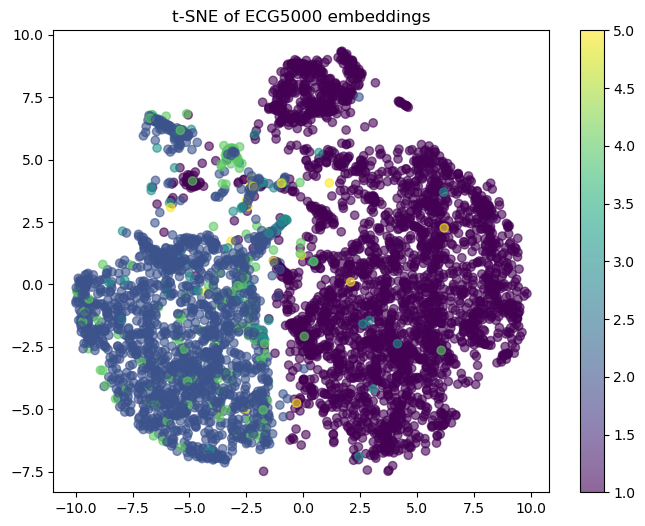

In [ ]:
signals, labels = get_ecg_signals()

embeddings_2d = get_manifolds_embeddings(encoder, signals, projection=PROJECTION)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=labels,
    cmap='viridis',
    alpha=0.6
)
plt.colorbar(scatter)
plt.title(f"{PROJECTION} of ECG5000 embeddings")